<h1>An introduction to S3, Boto and Nexrad on S3</h1>

<!--  Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. -->
<!-- !-- SPDX-License-Identifier: MIT-0 -->

Adapted from <a href="https://github.com/openradar/AMS_radar_in_the_cloud">AMS Short Course</a> which was adapted and thanks to the <a href="https://eng.climate.com/2015/10/27/how-to-read-and-display-nexrad-on-aws-using-python/">first tutorial</a> by Valliappa Lakshmanan, formerly at Climate Corp now at Google.

<a href="https://aws.amazon.com/s3">Amazon Simple Storage Service (Amazon S3)</a> is object storage with a simple web service interface to store and retrieve any amount of data from anywhere on the web. It is designed to deliver 99.999999999% durability, and scale past trillions of objects worldwide.

<a href="https://github.com/boto/boto3">Boto3</a> is a Python package that provides interfaces to Amazon Web Services.

In [1]:
import boto3
from datetime import timedelta, datetime
import os
import pyart
from matplotlib import pyplot as plt
import tempfile
import numpy as np

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
from botocore import UNSIGNED
from botocore.client import Config

s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

From https://aws.amazon.com/noaa-big-data/nexrad/ :

The NEXRAD Level II archive data is hosted in the “noaa-nexrad-level2” Amazon S3 bucket in S3’s US East region. The address for the public bucket is:

    http://noaa-nexrad-level2.s3.amazonaws.com

    https://noaa-nexrad-level2.s3.amazonaws.com

Each volume scan file is its own object in Amazon S3. The basic data format is the following:
    /<Year>/<Month>/<Day>/<NEXRAD Station>/<filename>

Where:

    is the year the data was collected
    is the month of the year the data was collected
    is the day of the month the data was collected
    is the NEXRAD ground station (map of ground stations)
    is the name of the file containing the data. 
These are compressed files (compressed with gzip). The file name has more precise timestamp information.

All files in the archive use the same compressed format (.gz). The data file names are, for example, KAKQ20010101_080138.gz. The file naming convention is:

    GGGGYYYYMMDD_TTTTTT

Where:

    GGGG = Ground station ID (map of ground stations) 
    YYYY = year 
    MM = month 
    DD = day 
    TTTTTT = time when data started to be collected (GMT)

Note that the 2015 files have an additional field on the file name. It adds “_V06” to the end of the file name. An example is KABX20150303_001050_V06.gz.

In [7]:
my_pref = '2024/10/10/KTBW/'
keys = []

paginator = s3_client.get_paginator('list_objects_v2')
operation_parameters = {'Bucket': 'noaa-nexrad-level2',
                        'Prefix': my_pref}
page_iterator = paginator.paginate(**operation_parameters)
for page in page_iterator:
    for object in page['Contents']:
        keys.append(object['Key'])
        # print(object['Key'])

In [8]:
from botocore.handlers import disable_signing

home_dir = os.path.expanduser('~')

s3 = boto3.resource('s3')
s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
s3.Object('noaa-nexrad-level2', keys[0]).download_file(os.path.join(home_dir,'nexrad_tempfile'))

In [9]:
radar = pyart.io.read(os.path.join(home_dir,'nexrad_tempfile'))

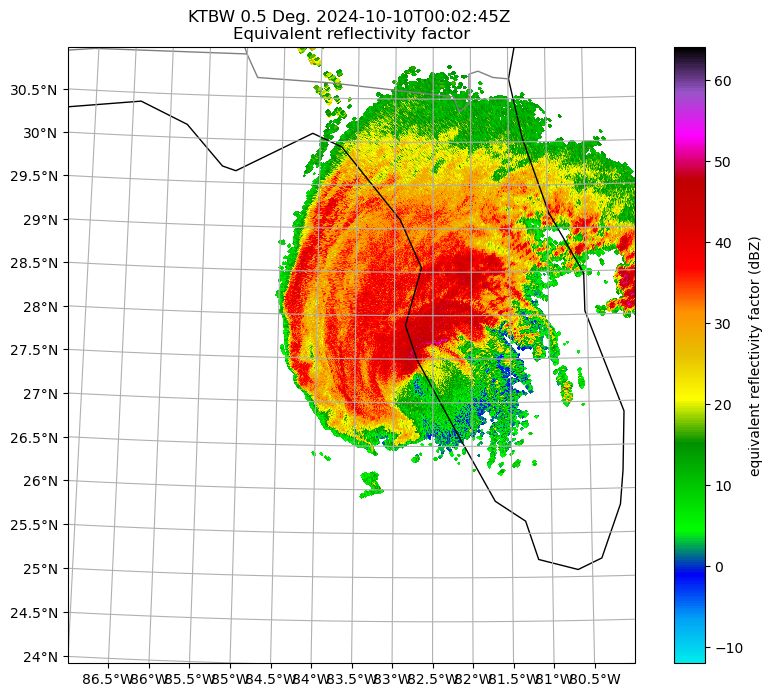

In [10]:
max_lat = 31
min_lat = 24
min_lon = -87
max_lon = -80

lal = np.arange(min_lat, max_lat, .5)
lol = np.arange(min_lon, max_lon, .5)


fig = plt.figure(figsize = [10,8])
my_display = pyart.graph.RadarMapDisplay(radar)
my_display.plot_ppi_map('reflectivity', sweep = 0, resolution = '110m',
                    vmin = -12, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)